In [105]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

In [106]:
import requests

# REST

Web services are increasingly implementing the REST (REpresentational State Transfer) architecture for developers to access their data. These include social media platforms like Twitter and Instagram, music apps like Spotify, real estate apps like Zillow, scientific sources of data such as the Climate Data Store, government data at the World Bank, and many many more. The basic behind REST is that every URL identifies a resource (data).

REST is considered stateless meaning that the server does not remember the client from one request to the next. This aspect of REST has a few advantages: the server and the client can understand any message received without seeing previous messages; code can be changed on either the client or server side without impacting the operation of the service; as well as being scalable, fast, modular, and independent. 

In this section, we work through an example to retrieve data from Spotify. We use both POST and GET methods in a series of requests to retrieve data on the songs by [The Clash](https://www.theclash.com/). Our example follows [Steven Morse's blog post](https://stmorse.github.io/journal/spotify-api.html).

:::{note}

In practice, we wouldn't write GET and POST requests ourselves for Spotify. Instead, we'd use the [`spotipy`](https://spotipy.readthedocs.io/en/2.22.1/) library, which has functions to interact with the [Spotify Web API]((https://developer.spotify.com/). That said, data scientists can often find themselves in the position of wanting to access data available via REST that doesn't have a Python library available. This section gives a peek behind the curtain and shows how libraries like `spotipy` work.

:::

Typically a REST application provides documentation with examples on how to request their data. Spotify has extensive documentation on how to access their data. It is geared to developers who want to build an app, but we can also access their service just to explore data. In order to do that, we need to register as a developer and get a client ID and secret. We then use these to identify us to Spotify in our HTTP requests.

After we register, we can begin to request data. There are basically two steps: authenticate and request resources. 

Authenticate
: We begin by authenticating ourselves. We issue a POST to provide the web service with our client ID and secrete. We provide these in the header. In return, we receive a token that authorizes us to make requests.
Authorizations must be sent to particular URL.

In [180]:
AUTH_URL = 'https://accounts.spotify.com/api/token'

In [ ]:
# The CLIENT_ID and CLIENT_SECRET variables can't be published, or else
# someone can make requests pretending to be us! We've hidden these secret
# values in this code.
auth_response = requests.post(AUTH_URL, {
    'grant_type': 'client_credentials',
    'client_id': CLIENT_ID,
    'client_secret': CLIENT_SECRET,
})

We provided our ID and secret in key:value pairs in the header of our POST request. Like with our GET in the previous section, we can check the status of our request:

In [181]:
auth_response.status_code

200

In [185]:
auth_response.headers['content-type']

'application/json'

The body of the response is JSON formatted content.  It contains the token that we need in the next step.  We convert it to a dictionary and save the access-token to use in the next step.  

In [186]:
auth_response_data = auth_response.json()

In [187]:
auth_response_data.keys()

dict_keys(['access_token', 'token_type', 'expires_in'])

In [191]:
access_token = auth_response_data['access_token']
token_type = auth_response_data['token_type']

Notice that we did hid our ID and secret so others reading this book can't imitate us. This request won't be successful without a valid ID and secret. For example, below we make up an ID and secret and try to authenticate. 

In [189]:
CLIENT_bad_ID = '0123456789'
CLIENT_bad_SECRET = 'a1b2c3d4e5'

auth_bad = requests.post(AUTH_URL, {
    'grant_type': 'client_credentials',
    'client_id': CLIENT_bad_ID,
    'client_secret': CLIENT_bad_SECRET,
})

We can check the status of this request.

In [190]:
auth_bad.status_code

400

In the previous section, we learned that a 400 status means that we issued a bad request. As another example, the web service limits the amount of time that our token is live, and it shuts us down if we take too much time making requests. A couple of times we ran into this issue:

```
res_clash.status_code

401
```

Now for the second step, let's get some data.

Resource Requests
: Requests for resources can then be made via GET for this service. Other services may require additional POSTs.  These requests must include the token we received from the web service in the first step. We can use this token many times. We pass the access token in the header of our GET request. First we construct the name_value pairs as a dictionary.

In [192]:
headers = {
    'Authorization': '{type} {token}'.format(type=token_type,token=access_token)
}

The developer API tells us that an artist's albums are available at URLs that look like:
'https://api.spotify.com/v1/artists/3RGLhK1IP9jnYFH4BRFJBS/albums'  where the code between 'artists/' and /albums' is the identifier for the artist. This particular code is for The Clash. And information about the tracks on an album is available at a URL like:  'https://api.spotify.com/v1/albums/49kzgMsxHU5CTeb2XmFHjo/tracks' where the identifier here is for the album. 

If we know the identifier for an artist, we can retrieve the IDs for their albums, and in turn we can get data about the tracks on the album. We'll do this for The Clash. We can get the ID for this band from Spotify's site.

We first set the base URL that remains the same across all of our requests and the artist ID for The Claseh, which we found on the Spotify site.

In [146]:
BASE_URL = 'https://api.spotify.com/v1/'
artist_id = '3RGLhK1IP9jnYFH4BRFJBS'

Our request begins with getting the group's albums. We construct the URL from the 'BASE_URL' and the 'artist_id' and pass the header with our access token.

In [198]:
res_clash = requests.get(BASE_URL + 'artists/' + artist_id + '/albums',
                        headers=headers,
                        params={'include_groups': 'album', 'limit': 50})

In [206]:
res_clash

<Response [200]>

Our request was successful. Now let's check the content-type of the response body.

In [254]:
res_clash.headers['content-type']

'application/json; charset=utf-8'

The resource returned from our request is JSON so we can load it into a dictionary.

In [208]:
clash_albums = res_clash.json()

 After poking around a bit, we can find that the album information are in the 'items' elements.

In [209]:
len(clash_albums['items'])

17

There are 17 albums. Let's find the keys for one of the albums.  

In [255]:
clash_albums['items'][0].keys()

dict_keys(['album_group', 'album_type', 'artists', 'available_markets', 'external_urls', 'href', 'id', 'images', 'name', 'release_date', 'release_date_precision', 'total_tracks', 'type', 'uri'])

Let's print the album ids, names, and release dates for the albums.

In [218]:
for album in clash_albums['items']:
    print('ID: ', album['id'], ' ', album['name'], '----', album['release_date'])

ID:  7nL9UERtRQCB5eWEQCINsh   Combat Rock + The People's Hall ---- 2022-05-20
ID:  3un5bLdxz0zKhiZXlmnxWE   Live At Shea Stadium ---- 2008-08-26
ID:  4dMWTj1OkiCKFN5yBMP1vS   Live at Shea Stadium (Remastered) ---- 2008
ID:  1Au9637RH9pXjBv5uS3JpQ   From Here To Eternity Live ---- 1999-10-04
ID:  70NjH8NkxcbYNvWAHnyv1e   From Here to Eternity (Live) [Remastered] ---- 1999
ID:  2gaW2Y3JhRCSNZC2FSibZk   Raw and Unfiltered ---- 1988-06-14
ID:  5xZ2mBLIMlMyrTfUMkTByT   Raw and Unfiltered: The Interviews ---- 1988-06-14
ID:  3E01XjnmC1HdxTE8dPuEkn   Cut The Crap ---- 1985-11-04
ID:  1sUuxJFnDGaL8nj6n4sGj5   Combat Rock ---- 1982-03-15
ID:  1ZH5g1RDq3GY1OvyD0w0s2   Combat Rock (Remastered) ---- 1982
ID:  2UxN3UKyS3Z5r0Sra8A5RF   Sandinista! (Remastered) ---- 1980
ID:  6FCzvataOZh68j8OKzOt9a   London Calling (Remastered) ---- 1979
ID:  3TZuLZx0zB3Q45aQXDswb9   London Calling (Expanded Edition) ---- 1979
ID:  4NEvCc6vHcsCPviWPCCrVg   Give 'Em Enough Rope (Remastered) ---- 1978
ID:  7LRgVof5HTOq

We see that several of the albums are remastered and live versions of others. We ignore this "duplication", and process them all. We cycle through the albums, pick up the ID, and for each album, request information about the tracks. 

In [155]:
tracks = []

for album in js_clash['items']: 
    tracks_url = f'{BASE_URL}albums/{album['id']}/tracks'
    res_tracks = requests.get(tracks_url, headers=headers)
    tracks_js = res_tracks.json()['items']
    
    for track in tracks_js:
        features_url = f'{BASE_URL}audio-features/{track['id']}'
        res_feat = requests.get(features_url, headers=headers)
        feat_js = res_feat.json()
        
        feat_js.update({
            'track_name': track['name'],
            'album_name': album['name'],
            'release_date': album['release_date'],
            'album_id': album['id']
        })
        
        tracks.append(feat_js) 

We put the track information into a data frame.

In [256]:
clash_df = pd.DataFrame(tracks)

In [257]:
clash_df.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature', 'track_name', 'album_name', 'release_date',
       'album_id'],
      dtype='object')

Finally, let's examine the relationship between danceability and loudness of the tracks.

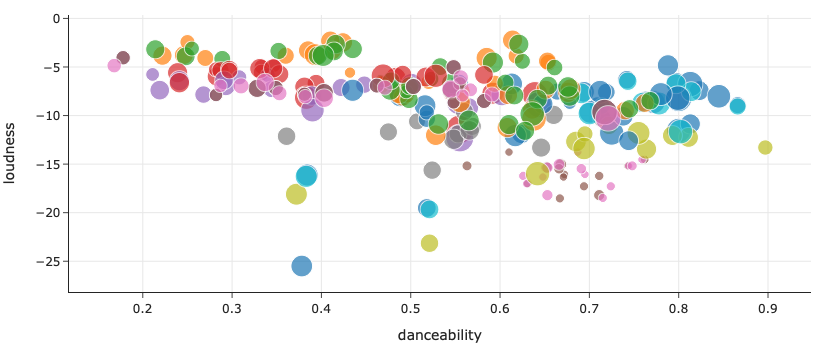

In [258]:
fig = px.scatter(clash_df, x='danceability', y='loudness', 
           color='album_name', size='duration_ms',
           width=600, height=350)

fig.update_layout(showlegend=False)
fig

This section talked about REST APIs, which often let programs download data as JSON.
That said, sometimes a REST API isn't available for the data we want.
Instead, we can extract data from webpages themselves since webpages are stored in HTML, a format similar to XML.
We describe how to work with these formats next. 